In [1]:
# region 1. Setup & Training Function
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset, WeightedRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_V2_L_Weights
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt
import time
import copy
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys
import warnings
import os

warnings.filterwarnings("ignore")

# --- HARDWARE OPTIMIZATION ---
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if DEVICE.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

if torch.cuda.is_bf16_supported() and DEVICE.type == 'cuda':
    AMP_DTYPE = torch.bfloat16
    PRECISION_NAME = "BFloat16 (BF16) + Channels Last + TF32"
else:
    raise RuntimeError("❌ GPU tidak support BF16! Script dihentikan demi performa.")

print(f"=== SYSTEM INFO ===\nDevice: {torch.cuda.get_device_name(0)}\nMode: {PRECISION_NAME}\n===================")

class CheckpointWrapper(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module
    def forward(self, x):
        return checkpoint(self.module, x, use_reentrant=False)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform: x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

def train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs, dataset_sizes, phase_name="Training", val_interval=1): 
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"\n--- Memulai {phase_name} ({num_epochs} Epochs) ---")

    for epoch in range(num_epochs):
        phases = ['train']
        if (epoch + 1) % val_interval == 0 or (epoch + 1) == num_epochs:
            phases.append('val')
            
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for phase in phases:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            
            pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()}", leave=False)

            for inputs, labels in pbar:
                inputs = inputs.to(device, memory_format=torch.channels_last, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                
                with torch.set_grad_enabled(phase == 'train'), \
                     torch.autocast(device_type=device.type, dtype=AMP_DTYPE, enabled=True): 
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{torch.sum(preds == labels.data)/inputs.size(0):.4f}'})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"  {phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
                    # --- REVISI: Safe Save (Anti-Crash Windows) ---
                    temp_path = f'best_model_{phase_name.replace(" ", "_").lower()}_temp.pth'
                    try:
                        torch.save(model.state_dict(), temp_path)
                    except Exception as e:
                        # Jika gagal save (file locked), beri peringatan tapi JANGAN stop training
                        print(f"  (!) Gagal menyimpan checkpoint sementara (Windows File Lock). Lanjut training... Error: {e}")
                        # Opsional: Coba simpan dengan nama unik agar tidak bentrok
                        try:
                            fallback_path = f'best_model_{phase_name.replace(" ", "_").lower()}_epoch{epoch}_temp.pth'
                            torch.save(model.state_dict(), fallback_path)
                            print(f"  (i) Tersimpan sebagai backup: {fallback_path}")
                        except:
                            pass
        
        if scheduler: scheduler.step()

    time_elapsed = time.time() - since
    print(f"Selesai: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s | Best Acc: {best_acc:.4f}")
    try: model.load_state_dict(best_model_wts)
    except: pass
    return model, history
# endregion

=== SYSTEM INFO ===
Device: NVIDIA GeForce RTX 5060
Mode: BFloat16 (BF16) + Channels Last + TF32


In [2]:
# region 2. Config & Data Loading
DATASET_PATH = 'Dataset'
IMG_SIZE = 224

# Batch Size
BATCH_SIZE_EXTRACT = 96
BATCH_SIZE_TUNE = 4
    
# --- REVISI: SUPER CEPAT (TESTING ONLY) ---
EPOCHS_FEATURE_EXTRACT = 2
EPOCHS_FINE_TUNE = 3
    
VALIDATION_SPLIT = 0.2 
LR_FEATURE_EXTRACT = 1e-2
LR_FINE_TUNE = 1e-3
WEIGHT_DECAY = 1e-2
LABEL_SMOOTHING = 0.1
    
PLOT_FILENAME = 'training_results_final.png'
CONFUSION_MATRIX_FILENAME = 'confusion_matrix_final.png'
BEST_MODEL_EXTRACT_PATH = 'best_model_extract.pth'
MODEL_SAVE_PATH = 'citrus_efficientnetv2l_final.pth'

def prepare_data():
    print("Mempersiapkan Data...")
    weights = EfficientNet_V2_L_Weights.DEFAULT
    preprocess = weights.transforms(antialias=True)

    train_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE + 32),
        transforms.CenterCrop(IMG_SIZE),
        preprocess
    ])
    val_transforms = preprocess

    try:
        full_dataset = datasets.ImageFolder(DATASET_PATH, transform=None)
        CLASSES = sorted(full_dataset.classes)
        NUM_CLASSES = len(CLASSES)
        print(f"Dataset: {len(full_dataset)} images | {NUM_CLASSES} classes")

        class_counts = np.bincount(full_dataset.targets)
        class_weights = [len(full_dataset) / c for c in class_counts]
        
        train_size = int((1 - VALIDATION_SPLIT) * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size], generator=torch.Generator().manual_seed(42))

        train_targets = [full_dataset.targets[i] for i in train_indices]
        sample_weights = [class_weights[t] for t in train_targets]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_indices), replacement=True)

        train_dataset = TransformedSubset(Subset(full_dataset, train_indices), train_transforms)
        val_dataset = TransformedSubset(Subset(full_dataset, val_indices), val_transforms)

        # ANTI-STUCK: Num Workers 0
        num_workers = 0 
        
        dataloaders_extract = {
            'train': DataLoader(train_dataset, batch_size=BATCH_SIZE_EXTRACT, sampler=sampler, num_workers=num_workers, pin_memory=True),
            'val': DataLoader(val_dataset, batch_size=BATCH_SIZE_EXTRACT, shuffle=False, num_workers=num_workers, pin_memory=True)
        }
        dataloaders_tune = {
            'train': DataLoader(train_dataset, batch_size=BATCH_SIZE_TUNE, sampler=sampler, num_workers=num_workers, pin_memory=True),
            'val': DataLoader(val_dataset, batch_size=BATCH_SIZE_TUNE, shuffle=False, num_workers=num_workers, pin_memory=True)
        }
        dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
        
        return dataloaders_extract, dataloaders_tune, dataset_sizes, CLASSES, NUM_CLASSES, weights

    except Exception as e:
        print(f"Error Dataset: {e}")
        sys.exit(1)
# endregion

In [3]:
# region 3. Feature Extraction
if __name__ == '__main__':
    print("\n=== TAHAP 1: FEATURE EXTRACTION (BF16 + Channels Last) ===")
    
    # --- PERBAIKAN: Cek & Load Data Otomatis ---
    # Memastikan variabel 'weights', 'num_classes', dll sudah tersedia
    try:
        # Cek apakah variabel penting sudah ada di memori
        if 'weights' not in locals() and 'weights' not in globals():
            raise NameError("weights not found")
        if 'dataloaders_extract' not in locals() and 'dataloaders_extract' not in globals():
            raise NameError("dataloaders not found")
    except NameError:
        print("(!) Data belum dimuat. Menjalankan prepare_data() otomatis...")
        try:
            # Panggil fungsi dari Sel 2
            dataloaders_extract, dataloaders_tune, dataset_sizes, class_names, num_classes, weights = prepare_data()
            print("(!) Data berhasil dimuat.")
        except NameError:
            raise RuntimeError("❌ Fungsi 'prepare_data' tidak ditemukan. Mohon jalankan Sel 2 terlebih dahulu!")

    # 1. Load Pretrained Model
    model_extract = models.efficientnet_v2_l(weights=weights)

    # 2. Gradient Checkpointing (Wajib untuk VRAM 8GB)
    for i in range(len(model_extract.features)):
        model_extract.features[i] = CheckpointWrapper(model_extract.features[i])

    # 3. Freeze Backbone
    for param in model_extract.features.parameters():
        param.requires_grad = False

    # 4. Ganti Classifier Head
    num_ftrs = model_extract.classifier[1].in_features
    model_extract.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(num_ftrs, num_classes)
    )
    
    # 5. Optimasi Memori: Channels Last
    model_extract = model_extract.to(DEVICE, memory_format=torch.channels_last)

    # Setup Training
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model_extract.classifier.parameters(), lr=LR_FEATURE_EXTRACT, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FEATURE_EXTRACT)

    # Jalankan Training (Validasi tiap epoch)
    model_extract, history_extract = train_model(
        model_extract, criterion, optimizer, scheduler, dataloaders_extract, DEVICE, 
        EPOCHS_FEATURE_EXTRACT, dataset_sizes, phase_name="Feature Extraction", val_interval=1
    )
    
    # Simpan Checkpoint
    torch.save(model_extract.state_dict(), BEST_MODEL_EXTRACT_PATH)
    print(f"Checkpoint Feature Extraction tersimpan: {BEST_MODEL_EXTRACT_PATH}")
# endregion


=== TAHAP 1: FEATURE EXTRACTION (BF16 + Channels Last) ===
(!) Data belum dimuat. Menjalankan prepare_data() otomatis...
Mempersiapkan Data...
Dataset: 38432 images | 5 classes
(!) Data berhasil dimuat.

--- Memulai Feature Extraction (2 Epochs) ---
Epoch 1/2


Train:   0%|          | 0/321 [00:00<?, ?it/s]

  Train Loss: 0.7606 Acc: 0.8689


Val:   0%|          | 0/81 [00:00<?, ?it/s]

  Val Loss: 0.6053 Acc: 0.9493
Epoch 2/2


Train:   0%|          | 0/321 [00:00<?, ?it/s]

  Train Loss: 0.6734 Acc: 0.9036


Val:   0%|          | 0/81 [00:00<?, ?it/s]

  Val Loss: 0.5549 Acc: 0.9603
Selesai: 20m 59s | Best Acc: 0.9603
Checkpoint Feature Extraction tersimpan: best_model_extract.pth


In [4]:
# region 4. Fine Tuning
if __name__ == '__main__':
    print("\n=== TAHAP 2: FINE-TUNING (BF16 + Channels Last) ===")
    
    # 1. Re-Init Model
    model_tune = models.efficientnet_v2_l(weights=None) 
    num_ftrs_tune = model_tune.classifier[1].in_features
    model_tune.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True),
        nn.Linear(num_ftrs_tune, num_classes)
    )

    # 2. Re-Apply Checkpointing
    for i in range(len(model_tune.features)):
        model_tune.features[i] = CheckpointWrapper(model_tune.features[i])

    # 3. Load Bobot dari Feature Extraction
    try:
        model_tune.load_state_dict(torch.load(BEST_MODEL_EXTRACT_PATH, map_location='cpu'))
        print("Bobot Feature Extraction dimuat.")
    except Exception as e:
        print(f"Gagal memuat bobot, menggunakan inisialisasi awal. Error: {e}")
        model_tune.load_state_dict(model_extract.state_dict())

    # 4. Unfreeze Semua Layer
    for param in model_tune.parameters():
        param.requires_grad = True

    # 5. Optimasi Memori: Channels Last
    model_tune = model_tune.to(DEVICE, memory_format=torch.channels_last)

    # Setup Training (LR lebih kecil)
    optimizer_tune = optim.AdamW(model_tune.parameters(), lr=LR_FINE_TUNE, weight_decay=WEIGHT_DECAY)
    scheduler_tune = optim.lr_scheduler.CosineAnnealingLR(optimizer_tune, T_max=EPOCHS_FINE_TUNE)

    # Jalankan Training (Validasi setiap 2 epoch untuk kecepatan)
    model_final, history_tune = train_model(
        model_tune, criterion, optimizer_tune, scheduler_tune, dataloaders_tune, DEVICE, 
        EPOCHS_FINE_TUNE, dataset_sizes, phase_name="Fine-Tuning", val_interval=2
    )

    # Simpan Model Final
    torch.save(model_final.state_dict(), MODEL_SAVE_PATH)
    print(f"Model Final tersimpan: {MODEL_SAVE_PATH}")
# endregion


=== TAHAP 2: FINE-TUNING (BF16 + Channels Last) ===
Bobot Feature Extraction dimuat.

--- Memulai Fine-Tuning (3 Epochs) ---
Epoch 1/3


Train:   0%|          | 0/7687 [00:00<?, ?it/s]

  Train Loss: 0.6049 Acc: 0.9124
Epoch 2/3


Train:   0%|          | 0/7687 [00:00<?, ?it/s]

  Train Loss: 0.4254 Acc: 0.9908


Val:   0%|          | 0/1922 [00:00<?, ?it/s]

  Val Loss: 0.5184 Acc: 0.9421
Epoch 3/3


Train:   0%|          | 0/7687 [00:00<?, ?it/s]

  Train Loss: 0.3963 Acc: 0.9988


Val:   0%|          | 0/1922 [00:00<?, ?it/s]

  Val Loss: 0.4680 Acc: 0.9602
Selesai: 125m 40s | Best Acc: 0.9602
Model Final tersimpan: citrus_efficientnetv2l_final.pth



=== VISUALISASI & EVALUASI ===


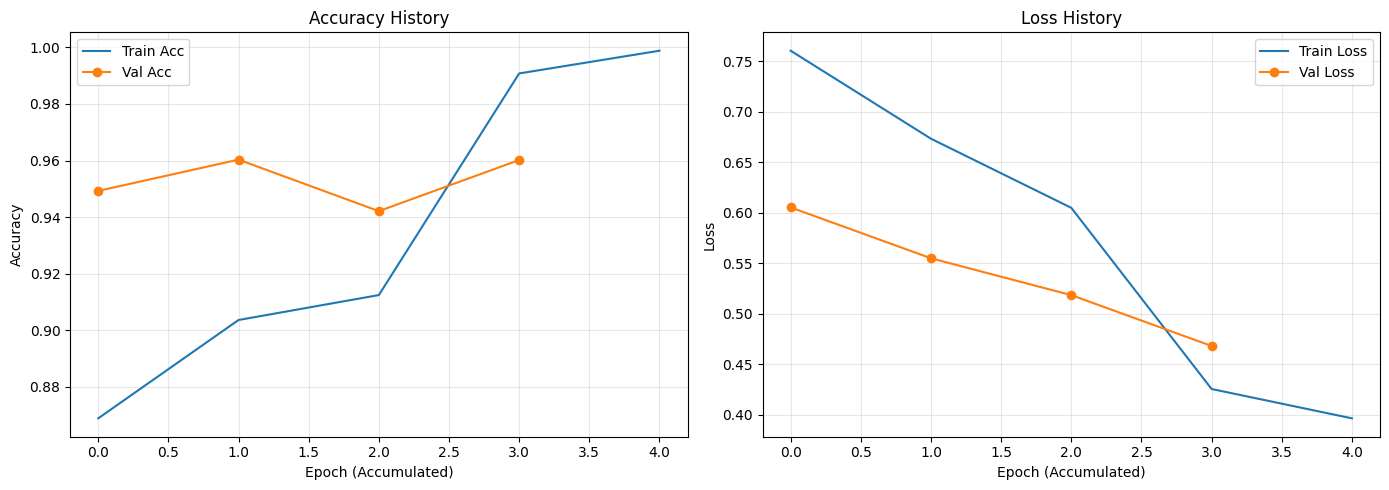

Plot tersimpan di: training_results_final.png

Menghitung Confusion Matrix...


Evaluasi Final:   0%|          | 0/1922 [00:00<?, ?it/s]

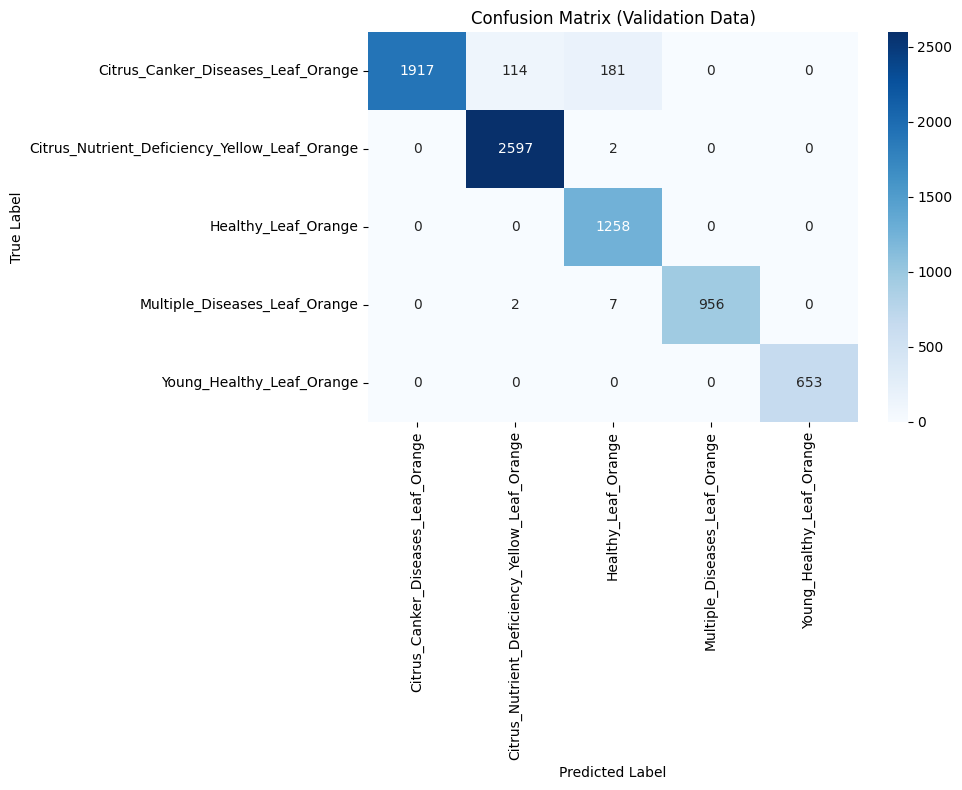

Matrix tersimpan di: confusion_matrix_final.png

--- PROSES SELESAI ---


In [5]:
# region 5. Visualization & Evaluation
if __name__ == '__main__':
    print(f"\n=== VISUALISASI & EVALUASI ===")
    
    # 1. Gabungkan History
    # Catatan: history_extract mungkin tidak ada jika Anda skip Sel 3 dan langsung load model
    train_acc = history_tune.get('train_acc', [])
    val_acc = history_tune.get('val_acc', [])
    train_loss = history_tune.get('train_loss', [])
    val_loss = history_tune.get('val_loss', [])

    if 'history_extract' in locals():
        train_acc = history_extract.get('train_acc', []) + train_acc
        val_acc = history_extract.get('val_acc', []) + val_acc
        train_loss = history_extract.get('train_loss', []) + train_loss
        val_loss = history_extract.get('val_loss', []) + val_loss

    # 2. Plotting
    plt.figure(figsize=(14, 5))
    
    # Grafik Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc', marker='o') # Marker untuk titik validasi
    plt.title('Accuracy History')
    plt.xlabel('Epoch (Accumulated)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss', marker='o')
    plt.title('Loss History')
    plt.xlabel('Epoch (Accumulated)')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOT_FILENAME)
    plt.show()
    print(f"Plot tersimpan di: {PLOT_FILENAME}")

    # 3. Confusion Matrix
    print(f"\nMenghitung Confusion Matrix...")
    if 'model_final' in locals():
        model_final.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders_tune['val'], desc="Evaluasi Final"):
                # Optimasi saat Evaluasi
                inputs = inputs.to(DEVICE, memory_format=torch.channels_last)
                labels = labels.to(DEVICE)
                
                with torch.autocast(device_type=DEVICE.type, dtype=torch.bfloat16, enabled=True):
                    outputs = model_final(inputs)
                    
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Plot Heatmap
        cf_matrix = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix (Validation Data)')
        plt.tight_layout()
        plt.savefig(CONFUSION_MATRIX_FILENAME)
        plt.show()
        print(f"Matrix tersimpan di: {CONFUSION_MATRIX_FILENAME}")
    else:
        print("Model final tidak ditemukan di memori.")

    print("\n--- PROSES SELESAI ---")
# endregion